# Install necessary libraries
 - Add `%%capture capt` wherever you don't want to see cell output

In [27]:
%%capture capt 
!pip3 install requests --user
!pip3 install pandas --user
!pip3 install selenium --user
!pip3 install tqdm --user 
!pip3 install json-stream --user
!pip3 install bigjson --user
!pip3 install seaborn --user
!pip3 install plotly --user
!pip3 install flashtext --user

In [5]:
OPEN_FDA_URL = "https://open.fda.gov/data/downloads/"
CATEGORY_TO_DOWNLOAD = "Human Drug Label" # Substitute this with values from dataset_categories list in the code
UNZIP_AUTOMATICALLY = True # Set this to true if downloaded file needs to be unzipped automatically

# Downloading Data
- All data can be downloaded from links in this [json](https://api.fda.gov/download.json) that openfda publishes daily
- So one way would be to parse this json daily, and download incremental files (sample code to parse json below)
- For now we just went with the below approach

In [36]:
import requests
r = requests.get('https://api.fda.gov/download.json')
print(r.json()['meta'])

# import urllib.request, json 
# with urllib.request.urlopen("http://maps.googleapis.com/maps/api/geocode/json?address=google") as url:
#     data = json.loads(url.read().decode())
#     print(data['meta'])

/usr/local/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning:

urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!



{'disclaimer': 'Do not rely on openFDA to make decisions regarding medical care. While we make every effort to ensure that data is accurate, you should assume all results are unvalidated. We may limit or otherwise restrict your access to the API in line with our Terms of Service.', 'terms': 'https://open.fda.gov/terms/', 'license': 'https://open.fda.gov/license/', 'last_updated': '2022-08-25'}


# Get all download URLs
 - Used Selenium and pandas libraries
 - Selenium instead of Beautiful Soup because we need to perform actions on the web page (i.e. it is not just a static html)

In [ ]:
# We use selenium (instead of requests & BeautifulSoup) because of the ACCEPT dialog box that shows up when opening the page
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import pandas as pd

options = Options()
options.headless = True
driver = webdriver.Chrome(options=options)

driver.get(OPEN_FDA_URL)
driver.find_element(By.CLASS_NAME,"ReactModalPortal").find_element(By.CLASS_NAME,"button").click()
categories_li = driver.find_element(By.ID,"downloads").find_elements(By.TAG_NAME,"li")
categories_li = [li for li in categories_li if len(li.find_elements(By.TAG_NAME,"h2"))==0] #Only lis which don't have h2 contain download links

dataset_categories = [li.get_attribute("id") for li in categories_li]
dataset_categories = [ele for ele in dataset_categories if ele] # Filter out empty elements

categories_li = [li for li in categories_li if li.get_attribute("id") in dataset_categories] # Get only what we need

i = 1
df = pd.DataFrame(columns = ["CATEGORY", "DOWNLOAD_LINKS"])
for li in categories_li:
    print("Current Category : {0}".format(li.get_attribute("id")))
    buttons = li.find_elements(By.TAG_NAME,"button")
    if len(buttons)!=0: #i.e. show all button exists
        driver.execute_script("arguments[0].click();", buttons[0])
        my_li = driver.find_element(By.ID,"downloads").find_element(By.ID,li.get_attribute("id"))
        link_lis = my_li.find_element(By.TAG_NAME,"ul").find_element(By.TAG_NAME,"ul").find_elements(By.TAG_NAME,"li")
        hrefs = [li.find_element(By.TAG_NAME,"a").get_attribute("href") for li in link_lis]
        hrefs = [href for href in hrefs if href]
        DOWNLOAD_LINKS =  ",".join(hrefs)
    else:
        my_li = driver.find_element(By.ID,"downloads").find_element(By.ID,li.get_attribute("id"))
        if len(my_li.find_elements(By.TAG_NAME,"ul"))!=0:
            link_lis = my_li.find_element(By.TAG_NAME,"ul").find_elements(By.TAG_NAME,"li")
            if len(link_lis)!=0:
                hrefs = [li.find_element(By.TAG_NAME,"a").get_attribute("href") for li in link_lis]
                hrefs = [href for href in hrefs if href]
                DOWNLOAD_LINKS =  ",".join(hrefs)
    
    df.loc[i] = [li.get_attribute("id"), DOWNLOAD_LINKS]
    i += 1

driver.close()


# Get download urls for category 
- <h3>Human Drug Label</h3>

In [ ]:
category_links = df[df["CATEGORY"]==CATEGORY_TO_DOWNLOAD]["DOWNLOAD_LINKS"].values[0].split(",")
category_links

# Download to folder in current directory

In [ ]:
import pathlib
import requests
import os
from tqdm import tqdm
import zipfile

def download_file(url, folder_name):
    url_file = url.split('/')[-1]
    actual_filename, actual_file_extension = os.path.splitext(url_file)

    # Get download directory if DOWNLOAD_DIR is set, otherwise current directory
    DOWNLOAD_DIR = os.getenv('DOWNLOAD_DIR', '.')
    pathlib.Path(DOWNLOAD_DIR + "/" + folder_name + "/downloads/").mkdir(
        parents=True, exist_ok=True)
    
    # If the file already exists, don't download it
    if(os.path.exists(DOWNLOAD_DIR + "/" + folder_name + "/downloads/" + url_file)):
        print("{file} already exists".format(file=url_file))
    else:
        r = requests.get(url, stream=True)
        print(f"Downloading {url_file}....")
        with open(os.path.join(DOWNLOAD_DIR + "/" + folder_name + "/downloads/", actual_filename), 'wb') as f:
            for chunk in r.iter_content(chunk_size=100000):
                if chunk:  # filter out keep-alive new chunks
                    f.write(chunk)
        renamed_file = actual_filename + actual_file_extension
        os.rename(os.path.join(DOWNLOAD_DIR + "/" + folder_name + "/downloads/",actual_filename),
                  os.path.join(DOWNLOAD_DIR + "/" + folder_name + "/downloads/",renamed_file))
    
    if UNZIP_AUTOMATICALLY:
        if actual_file_extension == ".zip":
            print(f"Unzipping {url_file}....")
            with zipfile.ZipFile(os.path.join(DOWNLOAD_DIR + "/" + folder_name + "/downloads/" + url_file), 'r') as zip_ref:
                zip_ref.extractall(DOWNLOAD_DIR + "/" + folder_name + "/downloads")
        
for link in tqdm(category_links):
    download_file(link,CATEGORY_TO_DOWNLOAD)

# Apache Spark 
- Pyspark is used as client only, actual apache spark server is started manually to keep server and client isolated and scaled/maintained separately 
- You could use the spark bundled with pyspark OR pyspark bundled with apache spark downloaded manually , however I chose to keep them separate for many convenient reasons (reach out if you have questions on this)

In [ ]:
%%capture capt
!pip3 install pyspark==3.3.0 --user

In [1]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

In [2]:
# https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkConf
config = SparkConf()
config.set("spark.driver.memory", "2g")
config.set("spark.executor.memory", "4g")

# Because you are likely running in local mode, it is a good practice to set the number of shuffle partitions
# to something that is going to fit local mode. By default, the value is 200, but there aren't many executors
# on this machine, its worth reducing this to 5
config.set("spark.sql.shuffle.partitions", "5")

# Cluster mode
# https://spark.apache.org/docs/latest/submitting-applications.html
config.setMaster("spark://192.168.0.109:7077") # DONT SET THIS If spark is started in local cluster mode

In [3]:
spark = SparkSession.builder.config(conf=config).master("spark://192.168.0.109:7077").appName("Flatten json").getOrCreate()
spark

# Big Json to jsonL (Optional Step)

In [ ]:
import bigjson

# Reads json file in streaming mode
with open(DOWNLOAD_DIR + "/" + CATEGORY_TO_DOWNLOAD + "/downloads/drug-label-0001-of-0011 copy.json", 'rb') as f:
    json_data = bigjson.load(f)

    # Open output file  
    with open('drug-label-0001-of-0011 copy.jsonl', 'w') as outfile:
        # Iterates over input json
        for data in json_data:
            # Converts json to a Python dict  
            dict_data = data.to_python()
            
            # Saves the output to output file
            outfile.write(json.dumps(dict_data)+"\n")

# Read sample json

In [6]:
# Read json
import os
DOWNLOAD_DIR = os.getenv('DOWNLOAD_DIR', '.')

df_sample = spark.read.json(DOWNLOAD_DIR + "/" + CATEGORY_TO_DOWNLOAD + "/downloads/drug-label-0002-of-0011.json",multiLine=True)
# df = spark.read.json("drug-label-0001-of-0011 copy.jsonl",multiLine=False)

df_sample.printSchema() # Prints readable schema, whereas sampledf.schema shows data types


root
 |-- meta: struct (nullable = true)
 |    |-- disclaimer: string (nullable = true)
 |    |-- last_updated: string (nullable = true)
 |    |-- license: string (nullable = true)
 |    |-- results: struct (nullable = true)
 |    |    |-- limit: long (nullable = true)
 |    |    |-- skip: long (nullable = true)
 |    |    |-- total: long (nullable = true)
 |    |-- terms: string (nullable = true)
 |-- results: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- abuse: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- abuse_table: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- accessories: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- active_ingredient: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- active_ingredient_table: array (nullable = true)
 |    |  

# Observation
 - The `meta` element can be ignored 
 - In fact deleting the meta tag is beneficial for processing the data into a dataframe from performance perspective (We anyways have all the data inside results array)

# Shell Commands (on mac)  - to remove meta tag
- `sed -i '' '/  "results": \[/,$!d' drug-label-0001-of-0011.json` - Delete all lines until
- `sed -i '' 's/  "results": \[/\[/g' drug-label-0001-of-0011.json` - Replace with empty `[`
- `sed -i '' -e '$ d' drug-label-0001-of-0011.json` - Remove `}` on the last line  

On non-mac ignore the empty single quotes

In [7]:
# Read json
import os
DOWNLOAD_DIR = os.getenv('DOWNLOAD_DIR', '.')

df = spark.read.json(DOWNLOAD_DIR + "/" + CATEGORY_TO_DOWNLOAD + "/downloads/drug-label-0001-of-0011.json",multiLine=True)
# df = spark.read.json("drug-label-0001-of-0011 copy.jsonl")

df.printSchema() # Prints readable schema, whereas sampledf.schema shows data types


root
 |-- abuse: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- abuse_table: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- accessories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- active_ingredient: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- active_ingredient_table: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- adverse_reactions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- adverse_reactions_table: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- animal_pharmacology_and_or_toxicology: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- animal_pharmacology_and_or_toxicology_table: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ask_doctor: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- ask

# Openfda Brand Name

In [24]:
import ast
my_brand_list = [ast.literal_eval(str(row["brand_name"])) for row in df.select("openfda.brand_name").collect() if row["brand_name"] is not None]
my_brand_list[0:10]

[['Polyethylene Glycol 3350, Sodium Chloride, Sodium Bicarbonate and Potassium Chloride - Unflavored'],
 ['Equate Lubricant Eye Drops'],
 ['benazepril hydrochloride and hydrochlorothiazide'],
 ['ACETAMINOPHEN AND CODEINE PHOSPHATE'],
 ['Esterified Estrogens and Methyltestosterone'],
 ['tobramycin and dexamethasone'],
 ['ADVAIR DISKUS'],
 ['Bisoprolol Fumarate and Hydrochlorothiazide'],
 ['cle de peau BEAUTE THE FOUNDATION N O50 TAN OCHER'],
 ['omeprazole sodium bicarbonate']]

# Openfda UPC

In [25]:
import ast
my_upc_list = [ast.literal_eval(str(row["upc"])) for row in df.select("openfda.upc").collect() if row["upc"] is not None]
my_upc_flat_list = [item for sublist in my_upc_list for item in sublist]
my_upc_flat_list = list(set(my_upc_flat_list)) # remove duplicates
len(my_upc_flat_list)

3742

# Openfda API (active pharmaceutical ingredient)

In [9]:
import ast
api_list = [ast.literal_eval(str(row["active_ingredient"])) for row in df.select("active_ingredient").collect() if row["active_ingredient"] is not None]
api_flat_list = [item for sublist in api_list for item in sublist]
api_flat_list = list(set(api_flat_list)) # remove duplicates
len(api_flat_list)

8284

In [14]:
api_flat_list[3]

'Drug Facts Active Ingredients Purpose (per suppository) Cocoa butter 88.44%...................................................................Protectant Phenylephrine hydrochloride 0.25%..............................................Vasoconstrictor'

# Brand -> API

In [63]:
from pyspark.sql import functions as F

df_brand_api = df.withColumn("brand_api", F.explode(F.arrays_zip("openfda.brand_name", "active_ingredient")))\
    .select("openfda.brand_name", "active_ingredient")

df_brand_api.show(10,truncate=False)

+------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|brand_name                                                                                            |active_ingredient                                                                                                                                                                                                                                                                 

In [64]:
df_brand_api.columns

['brand_name', 'active_ingredient']

In [57]:
from flashtext import KeywordProcessor
keyword_processor = KeywordProcessor()
import ast
my_api_lookup = ['Acetaminophen 250 mg', 'Aspirin 250 mg (NSAID)','Caffeine 65 mg']
[keyword_processor.add_keyword(x) for x in my_api_lookup]

for brand, api in df_brand_api.select("brand_name","active_ingredient").collect():
    current_brand = str(brand).replace('[','').replace(']','')
    current_api = str(api).replace('[','').replace(']','')
    if len(keyword_processor.extract_keywords(str(current_api))) != 0:
           print(f"Here is another one --> {current_brand}")


Here is another one --> 'Lil Drug Store Headache Relief Extra Strength'
Here is another one --> 'ADVIL DUAL ACTION WITH ACETAMINOPHEN'
Here is another one --> 'Medique Pain Off'
Here is another one --> 'Excedrin PM Triple Action Caplets'
Here is another one --> 'Physicians Care Extra Strength Pain Reliever'
Here is another one --> 'Headache Relief Extra Strength'
Here is another one --> 'EXTRA STRENGTH HEADACHE RELIEF'
Here is another one --> 'Headache Relief Extra Strength'
Here is another one --> 'Extra Strength Headache Relief'
Here is another one --> 'Headache Relief Extra Strength'
Here is another one --> 'health mart migraine relief'
Here is another one --> 'Excedrin Extra Strength'
Here is another one --> 'Excedrin Migraine Geltabs'
Here is another one --> 'Headache Relief'
Here is another one --> 'Cove Migraine Relief'
Here is another one --> 'Quality Choice Pain Relief Powder'
Here is another one --> 'Quality Choice Pain Relief Powder'
Here is another one --> 'Alka-Seltzer Han

# All ingredients are present

In [60]:
from flashtext import KeywordProcessor
keyword_processor = KeywordProcessor()
import ast
my_api_lookup = ['Acetaminophen 250 mg', 'Aspirin 250 mg (NSAID)','Caffeine 65 mg']
[keyword_processor.add_keyword(x) for x in my_api_lookup]

for brand, api in df_brand_api.select("brand_name","active_ingredient").collect():
    current_brand = str(brand).replace('[','').replace(']','')
    current_api = str(api).replace('[','').replace(']','')
    if (set(my_api_lookup).issubset(set(keyword_processor.extract_keywords(str(current_api))))):
           print(f"Here is another one --> {current_brand}")


Here is another one --> 'Lil Drug Store Headache Relief Extra Strength'
Here is another one --> 'Headache Relief Extra Strength'
Here is another one --> 'EXTRA STRENGTH HEADACHE RELIEF'
Here is another one --> 'Headache Relief Extra Strength'
Here is another one --> 'Headache Relief Extra Strength'
Here is another one --> 'Headache Relief'


# Openfda - Out of reach of children

In [8]:
import ast
mylist = [ast.literal_eval(str(row["keep_out_of_reach_of_children"])) for row in df.select("keep_out_of_reach_of_children").collect() if row["keep_out_of_reach_of_children"] is not None]
mylist[0:10]

[['Keep out of reach of children. If swallowed, get medical help or contact a Poison Control Center (1-800-222-1222) right away.'],
 ['Keep out of reach of children. If product is swallowed, get medical help or contact a Poison Control Center right away.'],
 ['Keep out of reach of children. If more than used for brushing is accidentally swallowed, get medical help or contact a Poison Control Center right away.'],
 ['Keep out of reach of children.', 'Keep out of reach of children.'],
 ['Keep out of reach of children. In case of overdose, get medical help or contact a Poison Control Center right away. Quick medical attention is critical for adults as well as for children even if you do not notice any signs or symptoms.'],
 ['KEEP OUT OF REACH OF CHILDREN SECTION AS WITH ALL MEDICATIONS, KEEP OUT OF REACH OF CHILDREM'],
 ['Keep out of reach of children. If product is swallowed, get medical help or contact a Poison Control Center right away .'],
 ['KEEP OUT OF REACH OF THE CHILDREN'],
 ['K

# Openfda - UPC, Brand and Manufacturer
- General hierarchy is Manufacturer(1) -> Brand (n) -> UPC (n) i.e 1-many-many relationship

In [9]:
from pyspark.sql import functions as F

df1 = df.withColumn("manufacturer_brand_upc", F.explode(F.arrays_zip("openfda.manufacturer_name", "openfda.brand_name","openfda.upc")))\
    .select("openfda.manufacturer_name", "openfda.brand_name","openfda.upc")

df1.show(5,truncate=False)

+---------------------------+---------------------------------------------+---------------------------------------------+
|manufacturer_name          |brand_name                                   |upc                                          |
+---------------------------+---------------------------------------------+---------------------------------------------+
|[Walmart, Inc.]            |[Equate Lubricant Eye Drops]                 |[0681131107099]                              |
|[SpecGx LLC]               |[ACETAMINOPHEN AND CODEINE PHOSPHATE]        |[0304060484108, 0304060483019, 0304060485051]|
|[SpecGx LLC]               |[ACETAMINOPHEN AND CODEINE PHOSPHATE]        |[0304060484108, 0304060483019, 0304060485051]|
|[SpecGx LLC]               |[ACETAMINOPHEN AND CODEINE PHOSPHATE]        |[0304060484108, 0304060483019, 0304060485051]|
|[ANI Pharmaceuticals, Inc.]|[Esterified Estrogens and Methyltestosterone]|[0362559149013, 0362559150019]               |
+-----------------------

In [10]:
from pyspark.sql.functions import countDistinct
df1.select(countDistinct("manufacturer_name")).show()

+---------------------------------+
|count(DISTINCT manufacturer_name)|
+---------------------------------+
|                             1096|
+---------------------------------+



In [11]:
import ast
mylist = [ast.literal_eval(str(row["manufacturer_name"])) for row in df1.select("manufacturer_name").collect() if row["manufacturer_name"] is not None]
flat_list = [item for sublist in mylist for item in sublist]
flat_list = list(set(flat_list)) # remove duplicates
len(flat_list)

1096

# Check if manufacturer array has more than 1 item - should not 

In [66]:
for sublist in mylist:
    if len(sublist) > 1:
        print(sublist)

### count Openfda - brands and upcs

In [13]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType

def count_brand(brand_array):
    if brand_array is not None:
        return len(ast.literal_eval(str(brand_array)))
    else:
        return 0
    
def count_upc(upc_array):
    if upc_array is not None:
        return len(ast.literal_eval(str(upc_array)))
    else:
        return 0

count_brand_udf = udf(lambda z: count_brand(z))
count_upc_udf = udf(lambda z: count_upc(z))

df1 = df1.withColumn("brand_count", count_brand_udf(col("brand_name")))
df1 = df1.withColumn("upc_count", count_upc_udf(col("upc")))
df1.show(5, truncate=False)

+---------------------------+---------------------------------------------+---------------------------------------------+-----------+---------+
|manufacturer_name          |brand_name                                   |upc                                          |brand_count|upc_count|
+---------------------------+---------------------------------------------+---------------------------------------------+-----------+---------+
|[Walmart, Inc.]            |[Equate Lubricant Eye Drops]                 |[0681131107099]                              |1          |1        |
|[SpecGx LLC]               |[ACETAMINOPHEN AND CODEINE PHOSPHATE]        |[0304060484108, 0304060483019, 0304060485051]|1          |3        |
|[SpecGx LLC]               |[ACETAMINOPHEN AND CODEINE PHOSPHATE]        |[0304060484108, 0304060483019, 0304060485051]|1          |3        |
|[SpecGx LLC]               |[ACETAMINOPHEN AND CODEINE PHOSPHATE]        |[0304060484108, 0304060483019, 0304060485051]|1          |3  

# This proves that manufacturer-brand is also 1:1
- i.e. manufacturer_name(1) -> brand_name(1) -> upc(n) is the association i.e. 1-1-many relationship

In [14]:
df1.filter(df1.brand_count > 1).show()

+-----------------+----------+---+-----------+---------+
|manufacturer_name|brand_name|upc|brand_count|upc_count|
+-----------------+----------+---+-----------+---------+
+-----------------+----------+---+-----------+---------+



In [15]:
df1.filter(df1.upc_count > 1).show()

+--------------------+--------------------+--------------------+-----------+---------+
|   manufacturer_name|          brand_name|                 upc|brand_count|upc_count|
+--------------------+--------------------+--------------------+-----------+---------+
|        [SpecGx LLC]|[ACETAMINOPHEN AN...|[0304060484108, 0...|          1|        3|
|        [SpecGx LLC]|[ACETAMINOPHEN AN...|[0304060484108, 0...|          1|        3|
|        [SpecGx LLC]|[ACETAMINOPHEN AN...|[0304060484108, 0...|          1|        3|
|[ANI Pharmaceutic...|[Esterified Estro...|[0362559149013, 0...|          1|        2|
|[ANI Pharmaceutic...|[Esterified Estro...|[0362559149013, 0...|          1|        2|
|[Mylan Pharmaceut...|[Bisoprolol Fumar...|[0303780505018, 0...|          1|        3|
|[Mylan Pharmaceut...|[Bisoprolol Fumar...|[0303780505018, 0...|          1|        3|
|[Mylan Pharmaceut...|[Bisoprolol Fumar...|[0303780505018, 0...|          1|        3|
|    [Cipla USA Inc.]|[omeprazole sodiu...|

In [16]:
df1.count()

3861

In [17]:
df1.distinct().count() #can apply dropDuplicates() too

2692

In [18]:
df2 = df1.dropDuplicates()
df2.show(truncate=False)

+-------------------------------------------------------------+------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+---------+
|manufacturer_name                                            |brand_name                                                        |upc                                                                                                                                                   |brand_count|upc_count|
+-------------------------------------------------------------+------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+---------+
|[Walmart, Inc.]                                              |[Equate Lubricant Eye Dro

# Get pyspark pandas DF (pyspark pandas api df is distributed whereas pandas df is not)

In [19]:
import pyspark.pandas as ps
ps_df = ps.DataFrame(df2)

In [24]:
ps_df["upc_count"] = ps.to_numeric(ps_df["upc_count"])
ps_df["brand_count"] = ps.to_numeric(ps_df["brand_count"])

In [25]:
# Do the below if jupyterlab doesn't render the image
import plotly.io as pio
pio.renderers.default = 'iframe' # or 'iframe' or 'notebook' or 'colab' or 'jupyterlab'

ps_df["upc_count"].plot.hist(bins=10)

## Get Openfda - brands and upcs for manufacturers

In [24]:
ps_df_group = ps_df.groupby(['manufacturer_name']).agg({"brand_count":"sum","upc_count":"sum"}).reset_index()

In [25]:
ps_df_group.head(5)

,manufacturer_name,brand_count,upc_count
0,[Padagis Israel Pharmaceuticals Ltd],2.0,7.0
1,"[Rising Pharma Holdings, Inc.]",4.0,9.0
2,[Pharmacia and Upjohn Company],1.0,2.0
3,[Edgewell Personal Care Brands LLC],8.0,16.0
4,[Dash Pharmaceuticals LLC],1.0,2.0


In [26]:
ps_df_group["manufacturer_name"].count()

1096

### brand_count and upc_count correlation

In [ ]:
# Do the below if jupyterlab doesn't render the image
import plotly.io as pio
pio.renderers.default = 'iframe' # or 'iframe' or 'notebook' or 'colab' or 'jupyterlab'
ps_df_group.plot.bar(x="brand_count",y="upc_count")

### manufacturer_name and brand_count bars

In [35]:
ps_df_group_pandas = ps_df_group.to_pandas()
ps_df_group_pandas

/usr/local/lib/python3.7/site-packages/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning:

`to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.



,manufacturer_name,brand_count,upc_count
0,[Padagis Israel Pharmaceuticals Ltd],2.0,7.0
1,"[Rising Pharma Holdings, Inc.]",4.0,9.0
2,[Pharmacia and Upjohn Company],1.0,2.0
3,[Edgewell Personal Care Brands LLC],8.0,16.0
4,[Dash Pharmaceuticals LLC],1.0,2.0
...,...,...,...
1091,[NV Perricone LLC],1.0,1.0
1092,[Publix Super Markets Inc],1.0,1.0
1093,[Quallent Pharmaceuticals Health LLC],1.0,1.0
1094,[Novartis Pharmaceuticals Corporation],1.0,1.0


<AxesSubplot:xlabel='manufacturer_name'>

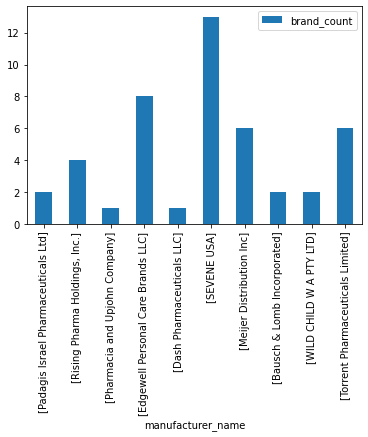

In [38]:
ps_df_group_pandas[0:10].plot.bar(x="manufacturer_name",y="brand_count")

### manufacturer and brand_count

In [44]:
# Do the below if jupyterlab doesn't render the image
import plotly.io as pio
pio.renderers.default = 'iframe' # or 'iframe' or 'notebook' or 'colab' or 'jupyterlab'

ps_df_group[0:2].plot.bar(x="manufacturer_name",y="brand_count")

In [ ]:
spark.stop()